# <center><span style = 'color:green'> Addressing Overfitting in Image Classification </span><center>

This notebook explores overfitting and possible techniques to solve it, such as data augmentation and dropout.
This notebook is a simplified version of the [tensorflow official tutorial](https://www.tensorflow.org/tutorials/images/classification). 

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

The flowers dataset is downloaded from google website and stored locally.
Bellow, `cache_dir='.'` stores the data in the current folder. `untar=True` unzips it.

In [15]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)

A copy of the dataset should be available, with a total of 3670 images.

In [16]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir
print(len(list(data_dir.glob('*/*.jpg'))))

3670


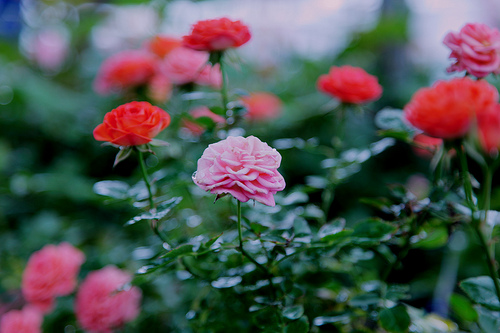

In [17]:
# visualizing some flowers using Pillow Library
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

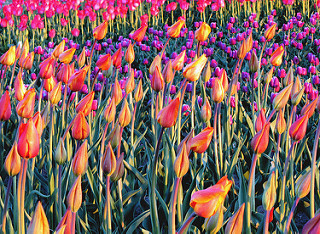

In [18]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

pretty \*-\*
# Opencv

## Creating dataset
For simplicity purposes, we will first read the data from disk using OpenCV. Later, we will work with Keras utilities.

The Flowers dataset contains 5 classes: Roses, daisy, dandelion, sunflowers, and tulips.

In [19]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [20]:
# checking image shape
img = cv2.imread(str(flowers_images_dict['roses'][0]))
img.shape


(243, 500, 3)

Resizing images to match dimensions.

In [21]:
# separate into images and labels for future test split
X, y = [], []

# resizing
for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(180,180))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])
        
X = np.array(X)
y = np.array(y)

Performing validation split, with 80% of the data being used for training, and 20% for validation

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)


## Standardize the data
The RGB channel values are in the range of \[0,255\]. For performance, we will normalize the values.

In [23]:
X_train = X_train / 255
X_test = X_test / 255


## Building CNN model


The Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D)each followed by a max pooling layer (tf.keras.layers.MaxPooling2D), and a fully-connected layer (tf.keras.layers.Dense) with 128 units and ReLU activation.



In [24]:
num_classes = 5

model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# compiling with SparseCategoricalCrossentropy since it is not hot encoded
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
# run after fitting
#model.summary()

In [26]:
model.fit(X_train, y_train, epochs=15)

Epoch 1/15
92/92 [==============================] - 15s 164ms/step - loss: 1.3961 - accuracy: 0.3931
Epoch 2/15
92/92 [==============================] - 14s 157ms/step - loss: 1.0128 - accuracy: 0.5998
Epoch 3/15
92/92 [==============================] - 15s 163ms/step - loss: 0.8205 - accuracy: 0.6829
Epoch 4/15
92/92 [==============================] - 15s 161ms/step - loss: 0.6366 - accuracy: 0.7691
Epoch 5/15
92/92 [==============================] - 15s 160ms/step - loss: 0.4104 - accuracy: 0.8569
Epoch 6/15
92/92 [==============================] - 15s 160ms/step - loss: 0.2407 - accuracy: 0.9247
Epoch 7/15
92/92 [==============================] - 16s 172ms/step - loss: 0.1623 - accuracy: 0.9510
Epoch 8/15
92/92 [==============================] - 15s 163ms/step - loss: 0.0939 - accuracy: 0.9748
Epoch 9/15
92/92 [==============================] - 14s 156ms/step - loss: 0.0531 - accuracy: 0.9884
Epoch 10/15
92/92 [==============================] - 15s 159ms/step - loss: 0.0345 - accura

In [27]:
model.evaluate(X_test,y_test)

23/23 [==============================] - 1s 44ms/step - loss: 2.5218 - accuracy: 0.6390


[2.5218076705932617, 0.6389645934104919]

The gap between train accuracy (1.) and test accuracy (0.64) is an indication of overfitting. It is possible to tackle overfitting with data augmentation (increasing the training data to prevent the model from learning from noise or unwanted details) and randomly dropping out neurons from the neural network.

## Data Augmentation
Here data augmentation is used to generate new data points from existing examples by using random transformations (zoom, flip, rotation).

In [28]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(180,
                                  180,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Original Image

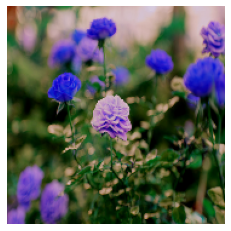

In [29]:
plt.axis('off')
plt.imshow(X[1])

Genarated image

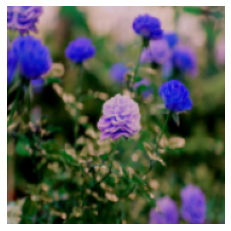

In [30]:
plt.axis('off')
plt.imshow(data_augmentation(X)[1].numpy().astype("uint8"))


## Dropout


Dropout reduces the overfitting by randomly setting the activation of some outputs from the units of the internal layer to zero.

In [31]:
num_classes = 5

model = Sequential([
  data_augmentation, #added augmentation
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), #added dropout
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model.fit(X_train, y_train, epochs=15)

Epoch 1/15
92/92 [==============================] - 16s 171ms/step - loss: 1.2344 - accuracy: 0.4772
Epoch 2/15
92/92 [==============================] - 16s 171ms/step - loss: 1.0345 - accuracy: 0.5913
Epoch 3/15
92/92 [==============================] - 16s 175ms/step - loss: 0.9170 - accuracy: 0.6434
Epoch 4/15
92/92 [==============================] - 16s 171ms/step - loss: 0.8479 - accuracy: 0.6730
Epoch 5/15
92/92 [==============================] - 251s 3s/step - loss: 0.7873 - accuracy: 0.6986
Epoch 6/15
92/92 [==============================] - 20s 211ms/step - loss: 0.7497 - accuracy: 0.7207
Epoch 7/15
92/92 [==============================] - 16s 179ms/step - loss: 0.7131 - accuracy: 0.7251
Epoch 8/15
92/92 [==============================] - 16s 173ms/step - loss: 0.6718 - accuracy: 0.7394
Epoch 9/15
92/92 [==============================] - 16s 172ms/step - loss: 0.6559 - accuracy: 0.7517
Epoch 10/15
92/92 [==============================] - 16s 175ms/step - loss: 0.6262 - accuracy

In [33]:
model.evaluate(X_test,y_test)

23/23 [==============================] - 1s 45ms/step - loss: 0.7638 - accuracy: 0.7343


[0.7638117671012878, 0.7343324422836304]

By employing data augmentation and dropout techniques, the accuracy on the training data dropped to 80%, but increase to 73% on the validation data. With the decreased gap between accuracies, data augmentation and dropout proved to be good options to tackle overfitting in this dataset.

# Keras Utility
## Creating dataset
Keras allows the user to create a dataset in a straightforward way, without the need to build up dictionaries by hand. It is possible to load, rescale, and split the data with just a couple of lines.

We will load the images from disk and turn them into a tensorflow dataset with tf.keras.utils.image_dataset_from_directory. Image rescaling and validation split parameters will be kept the same. 

In [34]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(180,180),
  batch_size=32)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [35]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(180,180),
  batch_size=32)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can also retrive the class names automatically.

In [36]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


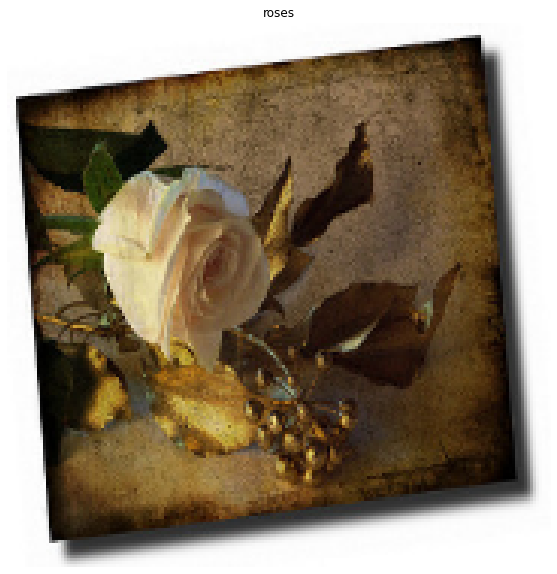

In [37]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.title(class_names[labels[0]])
    plt.axis("off")

## Building CNN model


The Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D)each followed by a max pooling layer (tf.keras.layers.MaxPooling2D), and a fully-connected layer (tf.keras.layers.Dense) with 128 units and ReLU activation.

Instead of rescaling the images before model definition, here we add a rescaling layer.


In [38]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(180, 180, 3)), #added rescaling
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)       

In [40]:
history = model.fit(train_ds, validation_data=val_ds, epochs=15)

Epoch 1/15
92/92 [==============================] - 16s 174ms/step - loss: 1.2418 - accuracy: 0.4636 - val_loss: 1.0300 - val_accuracy: 0.5845
Epoch 2/15
92/92 [==============================] - 16s 175ms/step - loss: 0.9598 - accuracy: 0.6304 - val_loss: 0.9911 - val_accuracy: 0.6076
Epoch 3/15
92/92 [==============================] - 16s 175ms/step - loss: 0.7531 - accuracy: 0.7112 - val_loss: 0.9357 - val_accuracy: 0.6281
Epoch 4/15
92/92 [==============================] - 16s 176ms/step - loss: 0.5243 - accuracy: 0.8113 - val_loss: 1.0848 - val_accuracy: 0.6376
Epoch 5/15
92/92 [==============================] - 16s 176ms/step - loss: 0.3573 - accuracy: 0.8753 - val_loss: 1.1264 - val_accuracy: 0.6553
Epoch 6/15
92/92 [==============================] - 16s 178ms/step - loss: 0.2192 - accuracy: 0.9275 - val_loss: 1.5393 - val_accuracy: 0.6144
Epoch 7/15
92/92 [==============================] - 16s 175ms/step - loss: 0.1413 - accuracy: 0.9547 - val_loss: 1.4186 - val_accuracy: 0.6676

The gap between train accuracy (1.) and test accuracy (0.65) is an indication of overfitting.

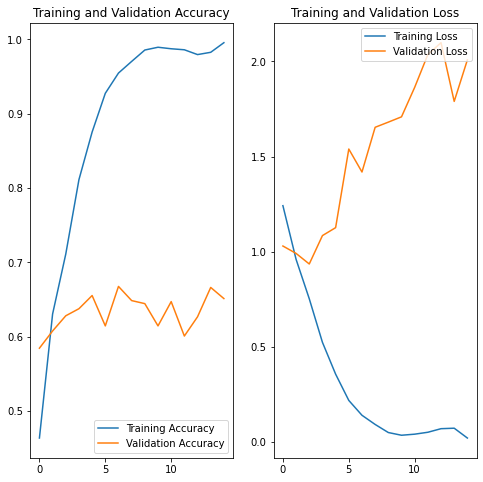

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

It is possible to tackle overfitting with data augmentation (increasing the training data to prevent the model from learning from noise or unwanted details) and randomly dropping out neurons from the neural network.

## Data Augmentation
Here data augmentation is used to generate new data points from existing examples by using random transformations (zoom, flip, rotation).

In [42]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(180, 180, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Generated image

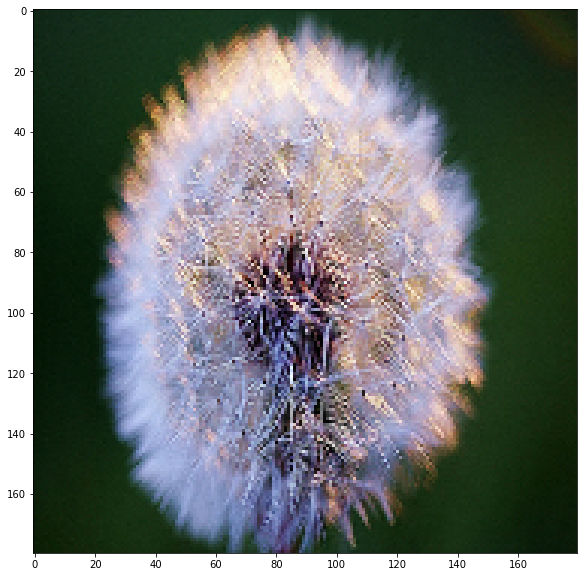

In [43]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    plt.imshow(data_augmentation(images)[0].numpy().astype("uint8"))

## Dropout
Dropout reduces the overfitting by randomly setting the activation of some outputs from the units of the internal layer to zero.

In [44]:
model = Sequential([
  data_augmentation, #added augmentation
  layers.Rescaling(1./255), #added rescaling
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), #added dropout
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [45]:
history = model.fit(train_ds, validation_data=val_ds,epochs=15)

Epoch 1/15
92/92 [==============================] - 18s 190ms/step - loss: 1.3471 - accuracy: 0.4084 - val_loss: 1.3107 - val_accuracy: 0.4319
Epoch 2/15
92/92 [==============================] - 17s 189ms/step - loss: 1.0878 - accuracy: 0.5603 - val_loss: 1.1012 - val_accuracy: 0.5109
Epoch 3/15
92/92 [==============================] - 18s 199ms/step - loss: 0.9759 - accuracy: 0.6213 - val_loss: 0.9568 - val_accuracy: 0.6144
Epoch 4/15
92/92 [==============================] - 18s 194ms/step - loss: 0.9041 - accuracy: 0.6601 - val_loss: 0.9218 - val_accuracy: 0.6362
Epoch 5/15
92/92 [==============================] - 18s 194ms/step - loss: 0.8585 - accuracy: 0.6754 - val_loss: 1.0136 - val_accuracy: 0.6308
Epoch 6/15
92/92 [==============================] - 18s 194ms/step - loss: 0.7929 - accuracy: 0.6935 - val_loss: 0.8836 - val_accuracy: 0.6649
Epoch 7/15
92/92 [==============================] - 20s 217ms/step - loss: 0.7723 - accuracy: 0.7016 - val_loss: 0.7958 - val_accuracy: 0.7030

By employing data augmentation and dropout techniques, the accuracy on the training data dropped to 80%, but increase to 73% on the validation data. With the decreased gap between accuracies, data augmentation and dropout proved to be good options to tackle overfitting in this case.

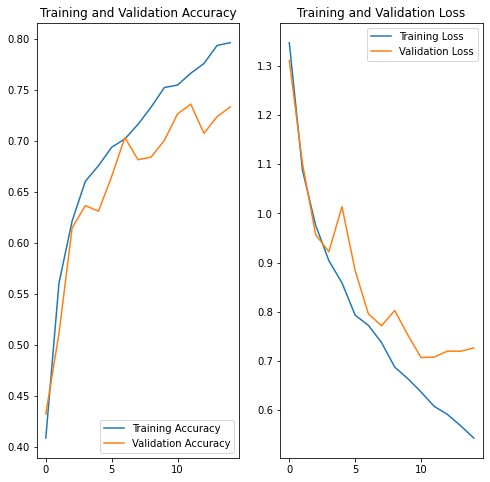

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()